# California Socioeconomic Relations Dataset
#### Luke Kearney, Tiger Cross, Joon-Ho Son, Theo Cohen, Jonas Scholz

***

- [1. Introduction](#intro)
    - [1.1 Dataset Background](#background)
    - [1.2 Project Structure](#structure)
- [2. Data Preparation](#data-preparation)
    - [2.1 Overview of Features](#data-features)
    - [2.2 Incomplete Data](#data-incomplete)
- [3. Feature Selection](#feature-selection)    
- [4. Exploratory data analysis](#data-analysis)
- [5. Case Study](#case-study)
- [6. Classification](#classification)
- [7. Summary](#summary)


TODO: TALK ABOUT MARGIN OF ERROR SOMEWHERE

***
## 1. Introduction<a class="anchor" id="intro"></a>
### 1.1 Dataset Background<a class="anchor" id="background"></a>


The given dataset consists of geodatabase data that combines data from the 2012-2016 American Community Survey (ACS) 5-year estimates and Topologically Integrated Geographic Encoding and Referencing (TIGER) Shapefiles. It can be found at https://www.census.gov/programs-surveys/acs/.

The ACS carry out this supplemental survey every year. More information about these surveys can be found at https://www.census.gov/programs-surveys/acs/. The 5-year estimates that comprises this data is an aggregation of 60 months of ACS data.

We began the task by getting a high level overview of the features. This notebook will explore various correlations discovered during analysis of the provided dataset, and in particular will have a focus on investigating factors affecting **educational attainment**. 

### 1.2 Project Structure<a class="anchor" id="structure"></a>

```Python
data/
data/raw/ # Raw data
data/interim/ # Interim data
data/processed/ # Processed data
imgs/ # Saved images
notebooks/
README.md
src/
```

***
## 2. Data Preparation<a class="anchor" id="data-processing"></a>
### 2.1 Overview of Features<a class="anchor" id="data-overview"></a>

We used pandas and dictionaries available in python to map the long column names for each csv into a more readable table so we could identify the different column names for each table that we could try and find a correlation between: 

In [3]:
# Standard python packages
import os
import sys
from pathlib import Path # For portable paths

# Other package imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
data_folder = Path("../data/")
raw_data_folder = data_folder / "raw" / "train"

metadata = pd.read_csv(raw_data_folder / "BG_METADATA_2016.csv")

In [5]:
def replace_columns(df):
    """
    Replace the 'short name' of each column of a given data frame with the 'long name' in the metadata file  
    
    Args:
        df: The dataframe to reformat headings on.
        
    Returns:
        The dataframe with reformatted headings.
    """
    labels = pd.Series(metadata["Full_Name"].values,index=metadata["Short_Name"]).to_dict()
    df = df.rename(columns=labels)
    return df

In [6]:
dfs = {}

for f in os.listdir(str(raw_data_folder)):
    print("Reformatted columns names of {}".format(f))
    df = pd.read_csv(raw_data_folder / f)
    df = replace_columns(df)
    dfs[f] = df

Reformatted columns names of X02_RACE.csv
Reformatted columns names of X99_IMPUTATION.csv
Reformatted columns names of X00_COUNTS.csv
Reformatted columns names of X20_EARNINGS.csv
Reformatted columns names of X01_AGE_AND_SEX.csv
Reformatted columns names of X03_HISPANIC_OR_LATINO_ORIGIN.csv
Reformatted columns names of X21_VETERAN_STATUS.csv
Reformatted columns names of X17_POVERTY.csv
Reformatted columns names of X12_MARITAL_STATUS_AND_HISTORY.csv
Reformatted columns names of X16_LANGUAGE_SPOKEN_AT_HOME.csv
Reformatted columns names of X22_FOOD_STAMPS.csv
Reformatted columns names of X08_COMMUTING.csv
Reformatted columns names of X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv
Reformatted columns names of X27_HEALTH_INSURANCE.csv
Reformatted columns names of X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv
Reformatted columns names of BG_METADATA_2016.csv
Reformatted columns names of X19_INCOME.csv
Reformatted columns names of X23_EMPLOYMENT_STATUS.csv
Reformatted columns names of X14_SCHOOL_ENROLLMENT.c

We identified our overall response variable `y` as The *population over the age of 25 that have attained a bachelors degree or higher*, This is from the following table:

In [9]:
dfs['X15_EDUCATIONAL_ATTAINMENT.csv']

,Unnamed: 0,GEOID,SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: No schooling completed: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: No schooling completed: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Nursery to 4th grade: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Nursery to 4th grade: Population 25 years and over -- (Margin of Error),...,FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering Related Fields: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering Related Fields: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Business: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Business: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Education: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Education: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),"FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Arts, Humanities and Other: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)","FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Arts, Humanities and Other: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error)",OBJECTID
0,0,15000US060014001001,2478,125,1274,109,0,12,9,13,...,24,0,12,0,12,0,12,0,12,3
1,1,15000US060014002001,843,79,427,54,0,12,0,12,...,22,7,11,6,9,0,12,26,22,4
2,2,15000US060014002002,716,82,313,52,0,12,0,12,...,16,0,12,0,12,0,12,13,19,5
3,3,15000US060014003001,973,329,501,189,0,12,0,12,...,21,0,12,0,12,0,12,13,25,6
4,4,15000US060014003002,1117,225,559,151,14,22,0,12,...,57,0,12,0,12,0,12,20,32,7
5,5,15000US060014003003,819,242,359,129,0,12,0,12,...,12,0,12,0,12,0,12,17,29,8
6,6,15000US060014003004,1215,230,434,109,0,12,0,12,...,12,0,12,0,12,0,12,11,23,9
7,7,15000US060014004001,1175,162,457,83,0,12,0,12,...,35,0,12,0,12,0,12,44,49,10
8,8,15000US060014004002,941,149,455,114,22,26,0,12,...,11,12,18,0,12,0,12,20,23,11
9,9,15000US060014004003,1187,197,590,179,0,12,0,12,...,25,8,13,0,12,0,12,0,12,12


## 2.2 Incomplete Data

The first step in preparing any dataset for use is to deal with missing values. We can gain an overall impression of the quanitity of incomplete data by calculating the percentage of rows/columns that contains a missing value.

In [10]:
def percent_na(df):
    """
    Prints percentage of rows and columns that contain a NaN value for a given dataframe 
    
    Args:
        df: The dataframe to calculate percentages for.
        
    Returns:
        A tuple of the percentage of rows and columns that contain a NaN value.
    """
    # Find rows and columns that contain a NaN value
    narows = df[df.isnull().any(axis=1)]
    nacols = df.columns[df.isna().any()].tolist()
    # Calculate the percentage of rows and columns that contain a NaN value
    percent_narows = round(len(narows)/df.shape[0]*100, 1)
    percent_nacols = round(len(nacols)/df.shape[1]*100, 1)
    return (percent_narows, percent_nacols)

In [11]:
for (name, df) in dfs.items():
    percent_narows, percent_nacols = percent_na(df)
    print("Percent missing data for {} : rows={}% columns={}%".format(name, percent_narows, percent_nacols))

Percent missing data for X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv : rows=0.0% columns=0.0%
Percent missing data for X99_IMPUTATION.csv : rows=100.0% columns=2.5%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X19_INCOME.csv : rows=100.0% columns=26.3%
Percent missing data for X14_SCHOOL_ENROLLMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X20_EARNINGS.csv : rows=22.5% columns=18.3%
Percent missing data for X12_MARITAL_STATUS_AND_HISTORY.csv : rows=0.0% columns=0.0%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X23_EMPLOYMENT_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X22_FOOD_STAMPS.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=100.0% columns=7.5%
Percent missing data for X21_VETERAN_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X02_RACE.csv : rows=0.0% columns=0.0%
Percent missing data for X00_COUNT

From this, we can see that some tables contain a very large proportion of rows with NaN values. For example, `X19_INCOME.csv` has 100% of its rows containing a NaN value.

After cheecking the percentage of missing data in rows and columns for each of the CSVs, we decided to drop the columns that had 20% or greater NaN values, as these were deemed too incomplete to be of significant use.

In [12]:
dfs_no_na = {}
for (name, df) in dfs.items():
    threshold=len(df)*0.8 # Keep columns with at least 80% data
    dfs_no_na[name] = df.dropna(thresh=threshold, axis=1) 
    print("{} columns dropped : {}".format(name, dfs[name].shape[1] - dfs_no_na[name].shape[1]))
    
del dfs # Free up some memory for my poor laptop

X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv columns dropped : 0
X99_IMPUTATION.csv columns dropped : 14
BG_METADATA_2016.csv columns dropped : 0
X19_INCOME.csv columns dropped : 61
X14_SCHOOL_ENROLLMENT.csv columns dropped : 0
X20_EARNINGS.csv columns dropped : 0
X12_MARITAL_STATUS_AND_HISTORY.csv columns dropped : 0
X03_HISPANIC_OR_LATINO_ORIGIN.csv columns dropped : 0
X23_EMPLOYMENT_STATUS.csv columns dropped : 0
X22_FOOD_STAMPS.csv columns dropped : 0
X08_COMMUTING.csv columns dropped : 44
X21_VETERAN_STATUS.csv columns dropped : 0
X02_RACE.csv columns dropped : 0
X00_COUNTS.csv columns dropped : 0
X01_AGE_AND_SEX.csv columns dropped : 36
X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv columns dropped : 0
X17_POVERTY.csv columns dropped : 10
X27_HEALTH_INSURANCE.csv columns dropped : 0
X07_MIGRATION.csv columns dropped : 82
X15_EDUCATIONAL_ATTAINMENT.csv columns dropped : 0
X16_LANGUAGE_SPOKEN_AT_HOME.csv columns dropped : 0


For the remaining incomplete data, our approach involved a basic imputation technique, filling each NaN with the mean value of that column. This method has clear disadvantages (in particular, decreasing the variance of the data), but in the interests of time we deemed this to be the most appropriate solution.

In [13]:
for (name, df) in dfs_no_na.items():
    dfs_no_na[name] = df.fillna(df.mean())

We perform a quick sanity check to ensure there are no more NaN values in the datasets and save the processed data.

In [15]:
for (name, df) in dfs_no_na.items():
    percent_narows, percent_nacols = percent_na(df)
    print("Percent missing data for {} : rows={}% columns={}%".format(name, percent_narows, percent_nacols))

Percent missing data for X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv : rows=0.0% columns=0.0%
Percent missing data for X99_IMPUTATION.csv : rows=0.0% columns=0.0%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X01_AGE_AND_SEX.csv : rows=0.0% columns=0.0%
Percent missing data for X14_SCHOOL_ENROLLMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X17_POVERTY.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=0.0% columns=0.0%
Percent missing data for X20_EARNINGS.csv : rows=0.0% columns=0.0%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X23_EMPLOYMENT_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X22_FOOD_STAMPS.csv : rows=0.0% columns=0.0%
Percent missing data for X21_VETERAN_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X02_RACE.csv : rows=0.0% columns=0.0%
Percent missing data for X00_COUNTS.csv : rows=0.0% colum

for (name, df) in dfs_no_na.items():
    df.to_csv(data_folder / "processed" / name)
    print(f"Saved {name}")

## 3. Feature Selection<a class="anchor" id="feature-selection"></a>

When calculating the correlation between any of our features, we decided to use the Pearson correlation coefficient as we looked into using both the kendall tau and spearmans correlation methods, but did not want to relate ordinal data or data that follows a monotonic function. As part of our feature selection process, we Initially looked at the correlations within individual CSVs to see which features had a similar correlation to each other so we could drop one of those as they would follow the same pattern with our response variable and pollute our results.

In [16]:
processed_data_folder = Path("../data/processed/")

../data/processed
X02_RACE.csv
../data/processed
X99_IMPUTATION.csv
../data/processed
X00_COUNTS.csv
../data/processed
correlations


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

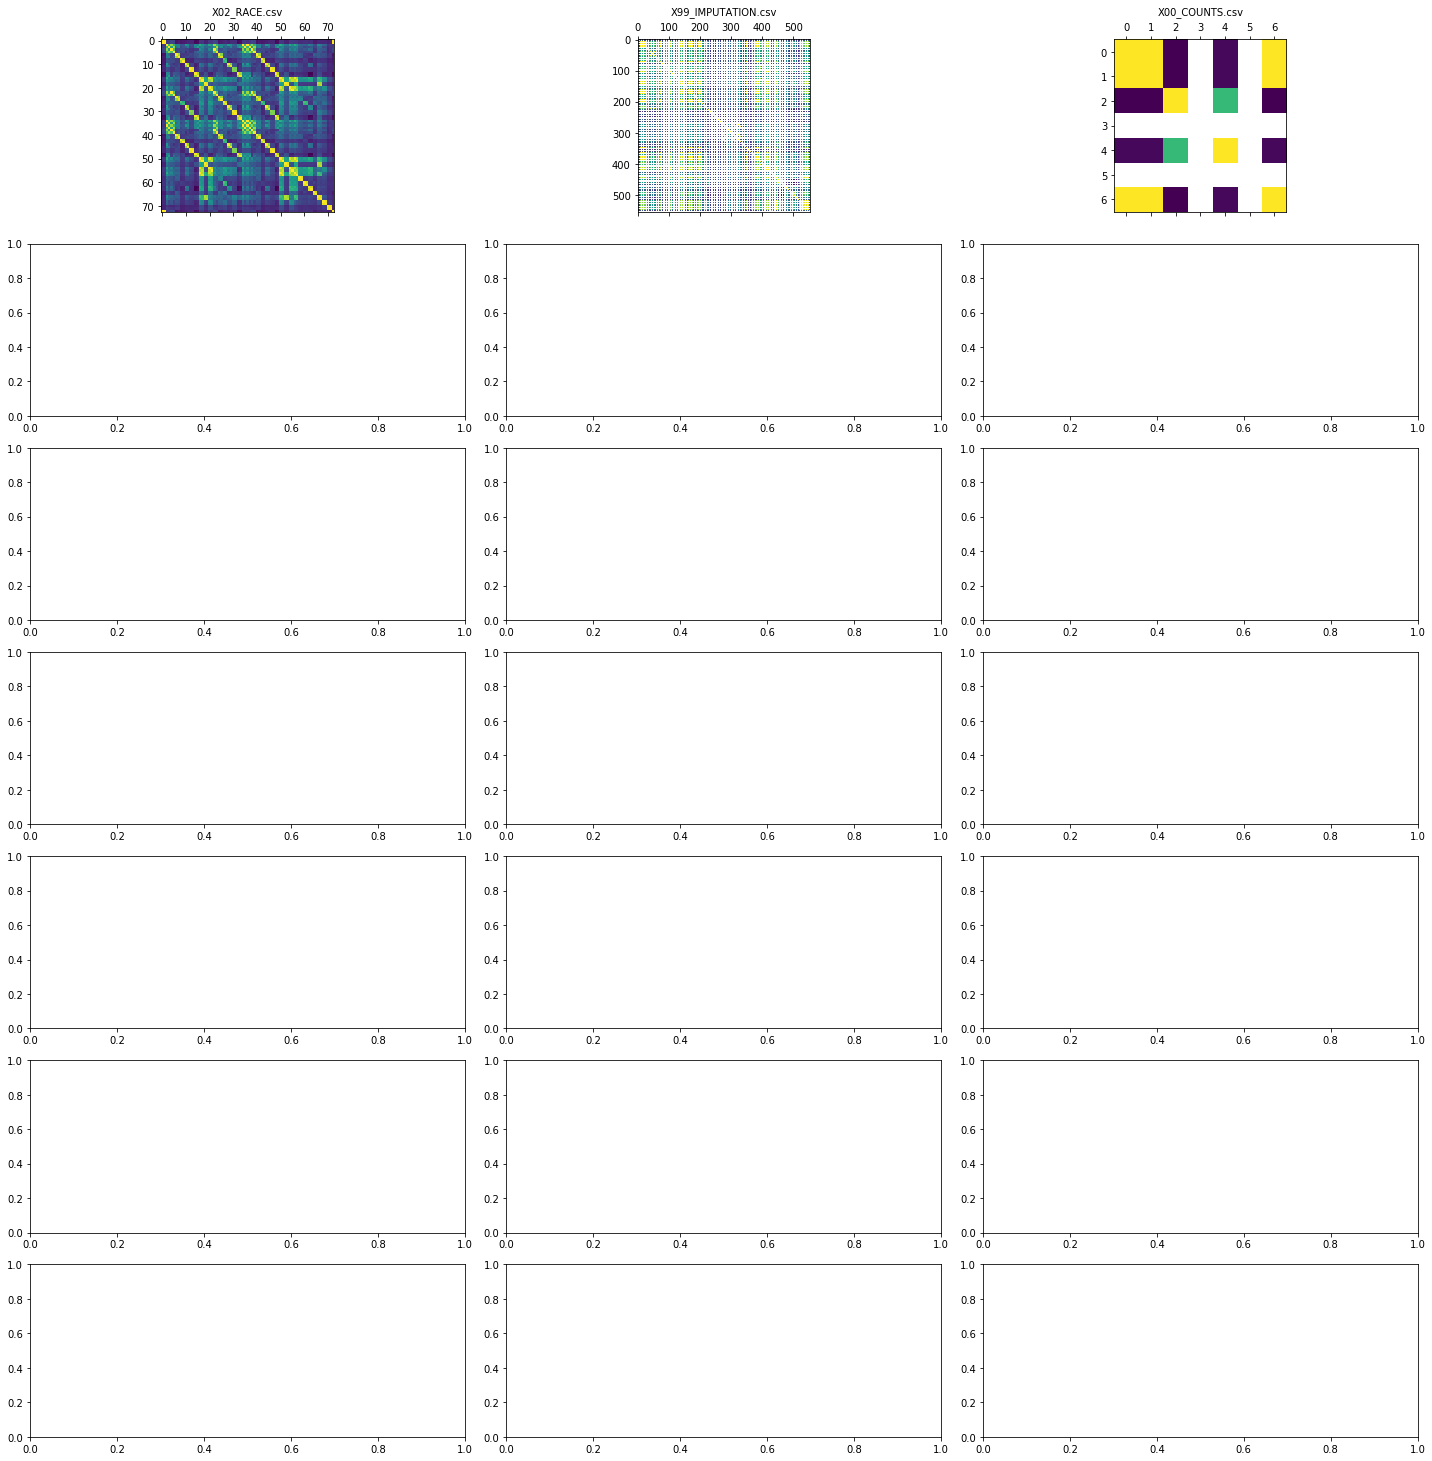

In [18]:
## WHAT THE FUCK IS WRONG HERE
def plot_corr_matrices(data_path):
    fig, axarr = plt.subplots(7,3, figsize=(20, 20))
    fig.tight_layout()
    
    ## Takes a loooong time to run
    for i, f in enumerate(os.listdir(str(data_path))):
        print(data_path / f)
        df = pd.read_csv(data_path / f)
        row = i // 3
        col = i % 3
        ax = axarr[row, col]
        ax.matshow(df.corr())
        ax.set_title(f, fontsize=10, pad=25)
    plt.show()

plot_corr_matrices(processed_data_folder)        

We then iterated through the correlation matrices and dropped features of similar correlation (similar colours in above heatmaps), This narrowed our dataset down a great deal and allowed us to focus more on the correlation of multiple features easier. We considered that it may have made our data more generic, although, we still considered more detailed features as shown when we train our model and in the case study

## 4. Exploratory Data Analysis<a class="anchor" id="data-analysis"></a>

We decided to explore all of the different CSVs and observe which features has the greatest correlation with our chosen y values

In [36]:
def find_educational_attainment_correlation(characteristic_csv_filepath, edu_attainment_csv_filepath, truncation_index = False, education_standard = 'bachelors'):
    '''
    education_standard = 'bachelors' or 'masters' or 'higher_education'
    '''

    edu_attainment = pd.read_csv(edu_attainment_csv_filepath)
    characteristic = pd.read_csv(characteristic_csv_filepath)

    no_bachelors = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Bachelor's degree: Population 25 years and over -- (Estimate)"]
    no_masters = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Master's degree: Population 25 years and over -- (Estimate)"]
    no_higher_ed = no_masters + no_bachelors

    edu_population = edu_attainment[edu_attainment.columns[3]]
    char_population = characteristic[characteristic.columns[3]]

    if truncation_index == False:
        truncation_index = len(no_masters)

    fractional_bachelors = no_bachelors/edu_population
    fractional_masters = no_masters/edu_population

    if education_standard == 'bachelors':
        y = no_bachelors[0:truncation_index]
    if education_standard == 'masters':
        y = no_masters[0:truncation_index]
    else:
        y = no_higher_ed[0:truncation_index]

    correlations = []
    column_name = []


    for column in characteristic.columns[4:]:
        absolute_x = characteristic[column][0:truncation_index]
        fractional_x = absolute_x/char_population[0:truncation_index]
        correlations.append(np.corrcoef(absolute_x, y)[0][1])
        column_name.append(characteristic[column].name)

    df = pd.DataFrame(correlations, column_name, columns = ['correlation'])
    '''
    returns max correlating factor, all correlations,
    '''

    return df.sort_values('correlation', ascending = False)

In [37]:
poverty_file = processed_data_folder / "X17_POVERTY.csv"
education_file = processed_data_folder / "X15_EDUCATIONAL_ATTAINMENT.csv"
correlations_df = find_educational_attainment_correlation(str(poverty_file), str(education_file), truncation_index=False, education_standard='higher_education')

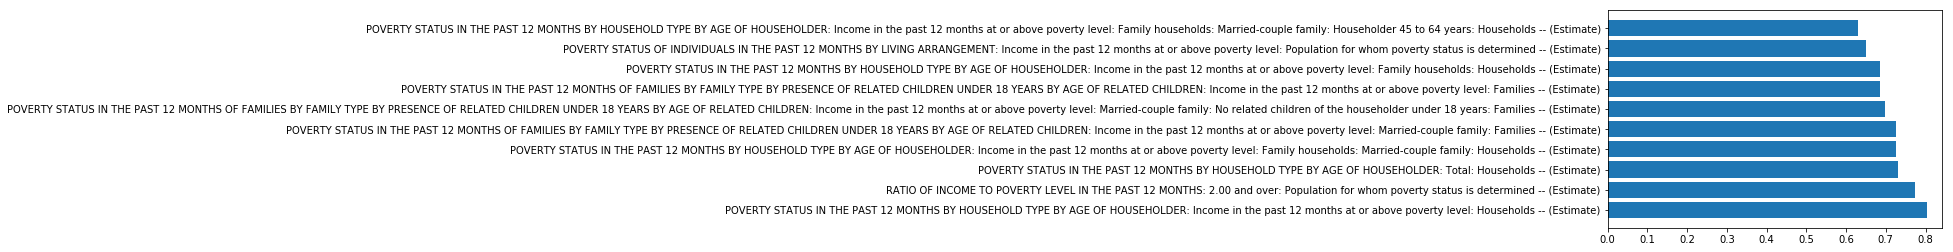

In [39]:
plt.barh(correlations_df.index[:10], correlations_df["correlation"].values[:10])
plt.show()

## Case Study: How gross income per capita affects educational attainment<a class="anchor" id="case-study"></a>

## Mapping the Data<a class="anchor" id="data-mapping"></a>

## Classification<a class="anchor" id="classification"></a>

## Summary<a class="anchor" id="summary"></a>